### Decision and Regression Trees

Decision and regression trees are tree-based algorithms widely used for **classification** and **regression** tasks in machine learning.

---

### **1. Decision Trees**
Used for **classification problems**.

- **Objective**: Partition the feature space into regions where each region contains data points of a single class.
- **Key Concepts**:
  - **Nodes**: Represent features or decisions.
  - **Edges**: Represent conditions (e.g., `feature < value`).
  - **Leaves**: Represent class labels.
- **Splitting Criteria**:
  - **Gini Impurity**: Measures the probability of a random element being misclassified.
  - **Entropy**: Measures information gain (reduction in uncertainty).

---

### **2. Regression Trees**
Used for **regression problems**.

- **Objective**: Partition the feature space into regions where each region has a constant predicted value (e.g., the mean of the target values in that region).
- **Key Concepts**:
  - Nodes, edges, and leaves as in decision trees.
  - Leaves store the predicted continuous value.
- **Splitting Criteria**:
  - **Mean Squared Error (MSE)**: Reduction in variance at each split.

---
### **Comparison of Decision vs. Regression Trees**

| **Feature**             | **Decision Trees**                     | **Regression Trees**                   |
|--------------------------|----------------------------------------|----------------------------------------|
| **Output**               | Discrete class labels                 | Continuous numerical values            |
| **Splitting Criterion**  | Gini impurity, entropy                | Mean squared error                     |
| **Use Case**             | Classification (e.g., spam detection) | Regression (e.g., predicting house prices) |


## Load Libararies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    roc_curve, 
    roc_auc_score
)
from sklearn.impute import SimpleImputer


## Set up model

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288847 entries, 0 to 288846
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 288847 non-null  object
 1   Month                         288847 non-null  object
 2   Year                          288847 non-null  int64 
 3   product                       288847 non-null  object
 4   sub_product                   260562 non-null  object
 5   issue                         288847 non-null  object
 6   sub_issue                     177490 non-null  object
 7   consumer_complaint_narrative  60742 non-null   object
 8   company_public_response       74230 non-null   object
 9   company                       288847 non-null  object
 10  state                         288776 non-null  object
 11  zipcode                       288776 non-null  object
 12  tags                          72753 n

c:\Users\NANAYAW\anaconda3\envs\ML-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\NANAYAW\anaconda3\envs\ML-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\NANAYAW\anaconda3\envs\ML-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

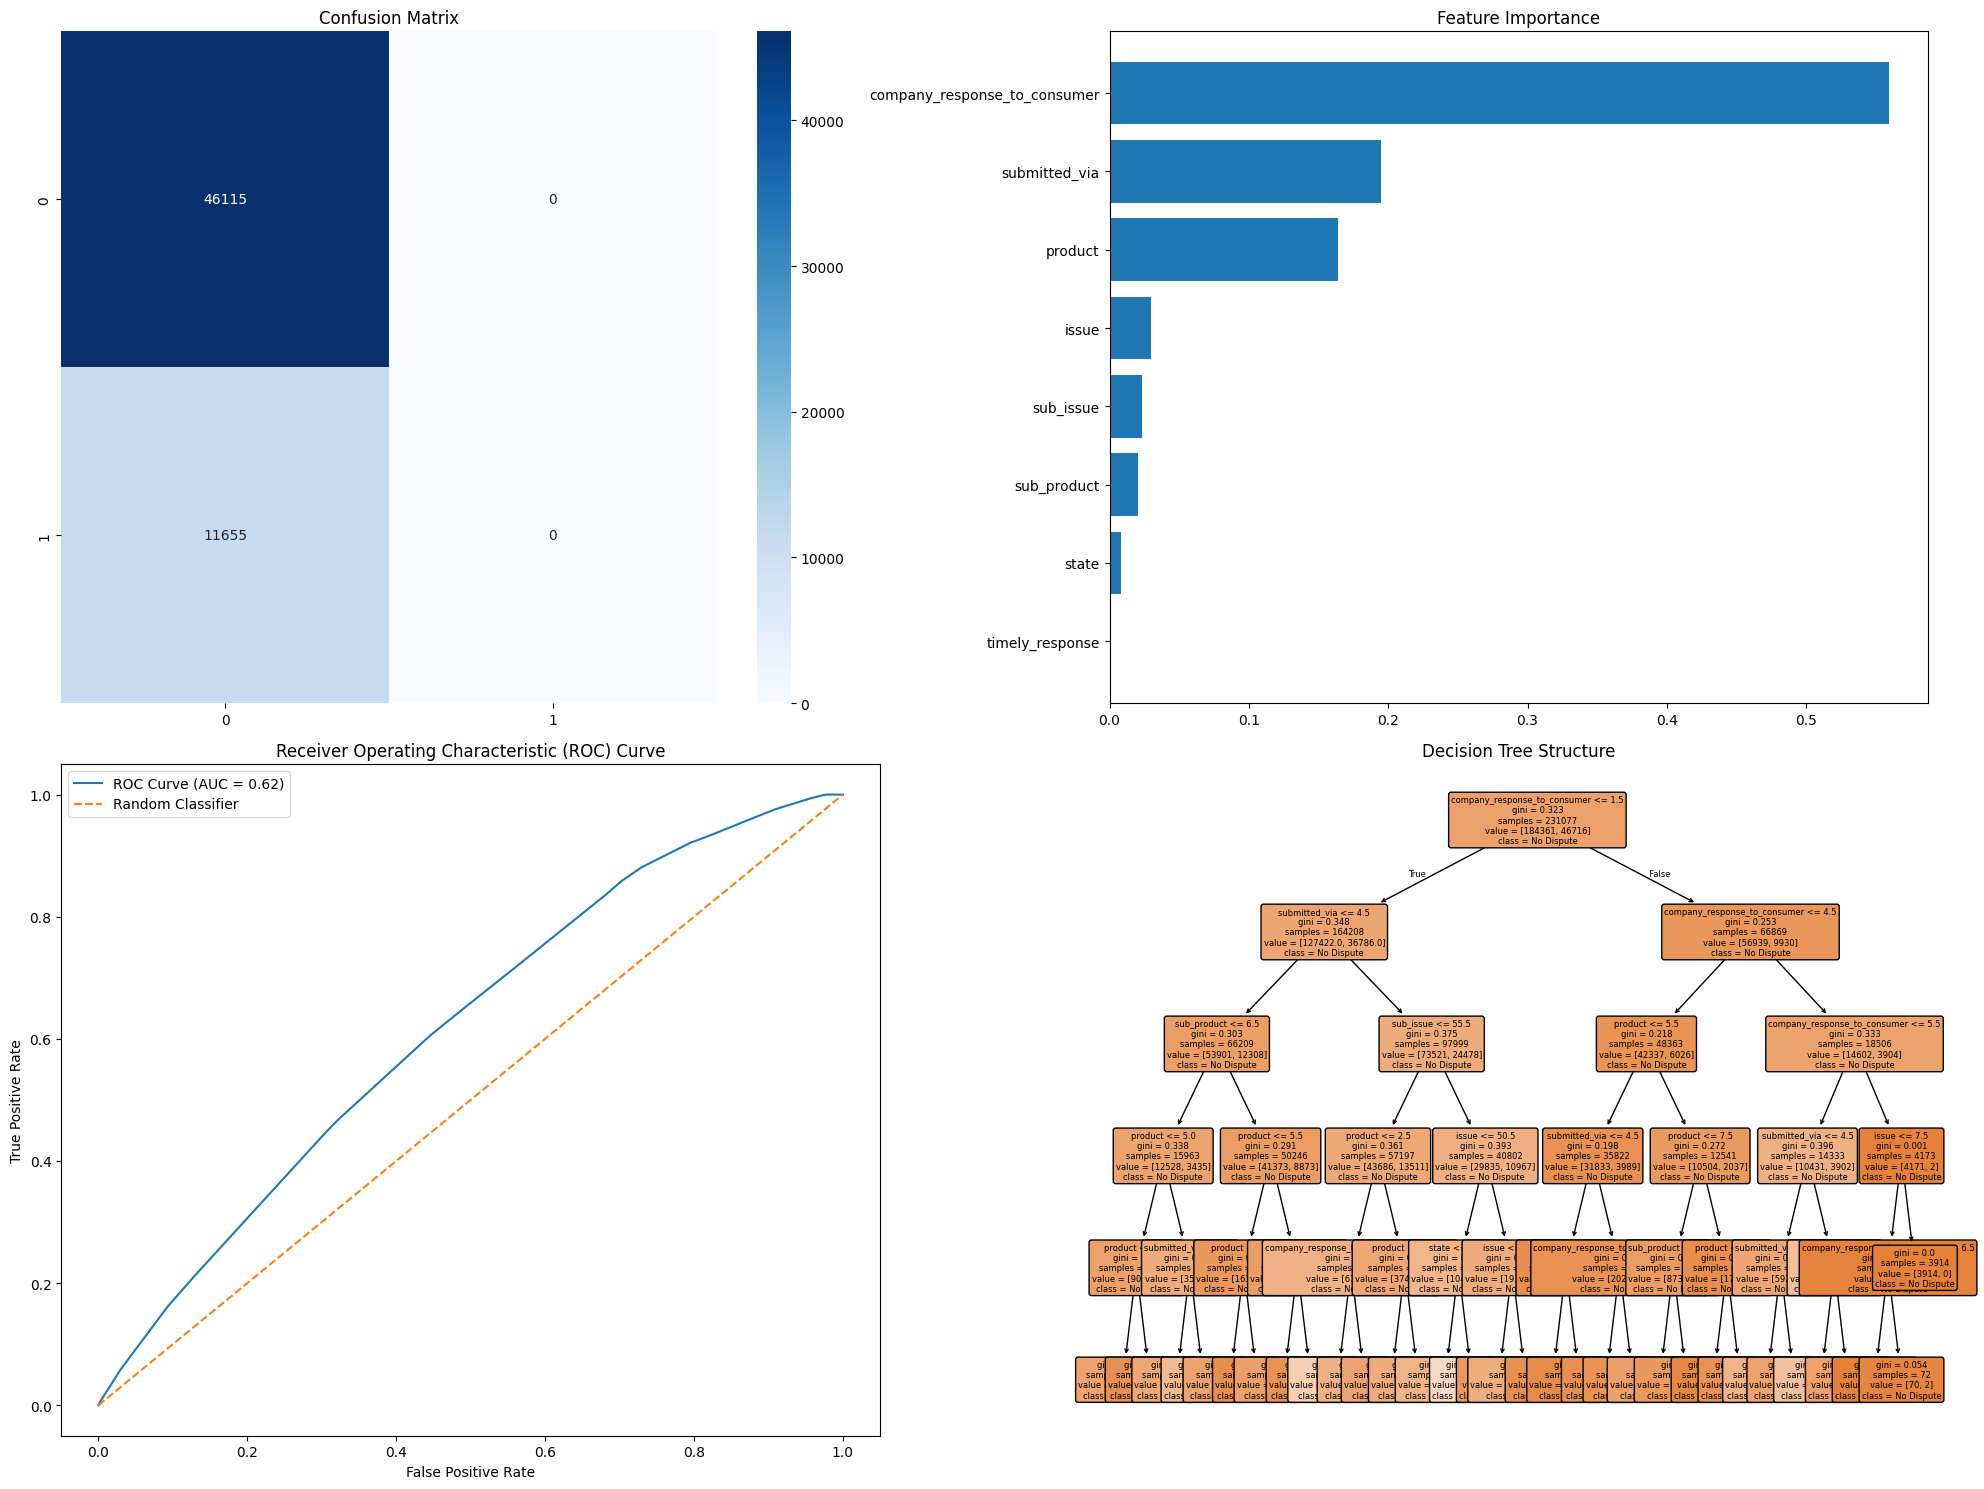


Model Performance Summary:
Accuracy: 79.83%
AUC Score: 0.6152

Feature Importance:
company_response_to_consumer: 0.5596
submitted_via: 0.1950
product: 0.1638
issue: 0.0299
sub_issue: 0.0230
sub_product: 0.0203
state: 0.0084
timely_response: 0.0000


In [1]:

def preprocess_data(df):
    """
    Comprehensive data preprocessing function
    
    Parameters:
    -----------
    df : pandas DataFrame
        Raw consumer complaints dataset
    
    Returns:
    --------
    tuple: (processed features, target variable)
    """
    # Create a copy to avoid modifying the original DataFrame
    data = df.copy()
    
    # Handle missing values
    # Drop columns with too many missing values
    data.dropna(thresh=len(data)*0.5, axis=1, inplace=True)
    
    # Select relevant features for prediction
    categorical_features = [
        'product', 'sub_product', 'issue', 'sub_issue', 
        'state', 'submitted_via', 'company_response_to_consumer',
        'timely_response'
    ]
    
    # Encode categorical variables
    le = LabelEncoder()
    for col in categorical_features:
        # Handle missing values first
        data[col] = data[col].fillna('Unknown')
        data[col] = le.fit_transform(data[col].astype(str))
    
    # Prepare target variable
    # Let's predict consumer dispute
    data['consumer_disputed'] = (data['consumer_disputed?'] == 'Yes').astype(int)
    
    # Select features
    features = [
        'product', 'sub_product', 'issue', 'sub_issue', 
        'state', 'submitted_via', 'company_response_to_consumer',
        'timely_response'
    ]
    
    X = data[features]
    y = data['consumer_disputed']
    
    # Impute any remaining missing values
    imputer = SimpleImputer(strategy='most_frequent')
    X_imputed = pd.DataFrame(
        imputer.fit_transform(X), 
        columns=X.columns
    )
    
    return X_imputed, y

def train_decision_tree(X, y):
    """
    Train Decision Tree Classifier
    
    Parameters:
    -----------
    X : DataFrame
        Feature matrix
    y : Series
        Target variable
    
    Returns:
    --------
    tuple: (trained model, test data)
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Train Decision Tree
    dt_classifier = DecisionTreeClassifier(
        max_depth=5,  # Prevent overfitting
        random_state=42
    )
    dt_classifier.fit(X_train, y_train)
    
    return dt_classifier, X_test, y_test

def evaluate_model(model, X_test, y_test, X):
    """
    Evaluate Decision Tree model
    
    Parameters:
    -----------
    model : DecisionTreeClassifier
        Trained Decision Tree model
    X_test : array-like
        Test feature matrix
    y_test : array-like
        Test target variable
    X : DataFrame
        Original feature matrix for feature names
    """
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Visualizations
    plt.figure(figsize=(20, 15))
    
    # 1. Confusion Matrix
    plt.subplot(221)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    
    # 2. Feature Importance
    plt.subplot(222)
    feature_importance = model.feature_importances_
    feature_names = X.columns
    indices = np.argsort(feature_importance)
    plt.barh(range(len(indices)), feature_importance[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title('Feature Importance')
    
    # 3. ROC Curve
    plt.subplot(223)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    # 4. Decision Tree Visualization
    plt.subplot(224)
    plot_tree(model, 
              feature_names=X.columns, 
              class_names=['No Dispute', 'Disputed'], 
              filled=True, 
              rounded=True,
              fontsize=6)
    plt.title('Decision Tree Structure')
    
    plt.tight_layout()
    plt.show()
    
    # Additional insights
    print("\nModel Performance Summary:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    print(f"AUC Score: {auc:.4f}")
    
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'auc': auc,
        'feature_importance': dict(zip(X.columns, feature_importance))
    }

def main():
    # Load the data
    df = pd.read_csv('C:/Users/NANAYAW/OneDrive/Documents/GitHub/FinalProject/consumer_complaints.csv')
    
    # Initial data exploration
    print("Dataset Information:")
    print(df.info())
    
    # Preprocess the data
    X, y = preprocess_data(df)
    
    # Train the model
    model, X_test, y_test = train_decision_tree(X, y)
    
    # Evaluate the model
    results = evaluate_model(model, X_test, y_test, X)
    
    # Print feature importance
    print("\nFeature Importance:")
    for feature, importance in sorted(
        results['feature_importance'].items(), 
        key=lambda x: x[1], 
        reverse=True
    ):
        print(f"{feature}: {importance:.4f}")

# Run the main function
if __name__ == '__main__':
    main()

## Observations:

### Performance:
- **Accuracy:** 79.83%
- **AUC Score:** 0.6152 (indicating moderate discrimination capability).

### Feature Importance:
- `company_response_to_consumer` is the most critical feature, contributing significantly to predictions.
- Features like `timely_response` have little to no importance.

### Decision Tree:
- Limited depth reduces the risk of overfitting but might underfit the data.
